# 1. Predicting Gender of Brazilian Names Using Deep Learning


## 1.1 Necessary libraries

In [21]:
!pip uninstall tensorflow
!pip uninstall keras

Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.12.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
y

y
y
y

n
n
  Successfully uninstalled tensorflow-2.12.0
Found existing installation: keras 2.12.0
Uninstalling keras-2.12.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras-2.12.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras/*
Proceed (Y/n)? y
  Successfully uninstalled keras-2.12.0


In [26]:
!pip install tensorflow==2.12.0
!pip install keras==2.12.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.0 MB/s eta 0:00:00


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd                       
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow import keras
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten, GRU, SimpleRNN, LSTM, Bidirectional, Activation, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [2]:
print(keras.__version__)

2.12.0


In [3]:
import tensorflow as tf

print(tf.__version__)

print(tf.__version__)

2.12.0
2.12.0


## 1.2 Download the dataset

In [4]:
"""
import requests
url = "https://data.brasil.io/dataset/genero-nomes/nomes.csv.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)
"""
df = pd.read_csv('/content/drive/MyDrive/gender-classification-main/dataset/nomes.csv.gz') 
df.head()

,alternative_names,classification,first_name,frequency_female,frequency_male,frequency_total,frequency_group,group_name,ratio
0,AILINE|ALEINE|ALIINE|ALINE|ALINER|ALINHE|ALINN...,F,AALINE,66.0,NaN,66,530550,ALINE,1.0
1,ARAAO|ARAO,M,AARAO,NaN,281.0,281,3526,ARAO,1.0
2,AHARON|AROM|ARON|ARYON|HARON,M,AARON,NaN,676.0,676,3442,ARON,1.0
3,ADA|ADAH|ADAR|ADHA|HADA,F,ABA,82.0,NaN,82,5583,ADA,1.0
4,NaN,M,ABADE,NaN,57.0,57,57,ABADE,1.0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ratio = 1.0
#df = df[df['ratio'] == 1.0].copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100787 entries, 0 to 100786
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   alternative_names  70745 non-null   object 
 1   classification     100787 non-null  object 
 2   first_name         100787 non-null  object 
 3   frequency_female   60484 non-null   float64
 4   frequency_male     50932 non-null   float64
 5   frequency_total    100787 non-null  int64  
 6   frequency_group    100787 non-null  int64  
 7   group_name         100787 non-null  object 
 8   ratio              100787 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.9+ MB


### 1.2.1 Preparing the data 

In [7]:
y = df['classification'].astype("category").cat.codes.values    # y labels into numbers 0 is F and 1 is M
names = df['first_name'].apply(lambda x: x.lower())             # input names

In [8]:
print("M : " + str(sum(y==1)))
print("F : " + str(sum(y==0)))
print(len(y))

M : 45537
F : 55250
100787


## 1.3 Encoding Words

Neural networks can only learn to find patterns in numerical data, so it is necessary to convert our data into numeric values with word encoding or tokenization. 

In [12]:
#word encoding
maxlen = 20                                               # max lenght of a name
'''Define a vocabulary which corresponds to all the unique letters encountered'''
vocab = set(' '.join([str(i) for i in names]))            # creating a vocab
vocab.add('END')
len_vocab = len(vocab)
''' The dictionary maps each letter of vocabulary to a number '''
char_index = dict((c, i) for i, c in enumerate(vocab))    # creating a dictionary

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    aux = np.zeros(len_vocab);
    aux[i] = 1
    return list(aux)

# Truncate names and create the matrix
def prepare_encod_names(X):
    vec_names = []
    trunc_name = [str(i)[0:maxlen] for i in X]  # consider only the first 20 characters
    for i in trunc_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        vec_names.append(tmp)
    return vec_names

In [14]:
x = prepare_encod_names(names.values)   # Now the names are encod as a vector of numbers 

## 1.4 Split the data into test and train

In [15]:
# train, val, test set will be 60%, 20%, 20% of the dataset respectively
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=40)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

In [16]:
x_train.shape

(64503, 20, 28)

In [17]:
y_train.shape

(64503,)

In [18]:
# Metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
# Callbacks
callbacks = [EarlyStopping(monitor='val_f1_score', mode="max", patience=5)]

In [20]:
# Results
def results(scores):
    print("Accuracy: %.2f%%" % (scores[1]*100))
    print("F1 score: %.2f%%" % (scores[2]*100)) 

## 1.5 Building the CNN Model

In [21]:
"""
checkpoint_filepath = './models/cnn_softmax'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='f1_score',
    mode='max',
    save_best_only=True)
"""
CNNmodel = keras.Sequential()
CNNmodel.add(Conv1D(256, 3, activation='relu', kernel_initializer='he_uniform', input_shape=(20, 28)))
CNNmodel.add(Conv1D(256, 3, activation='relu'))
CNNmodel.add(Flatten())
CNNmodel.add(Dropout(0.2))
CNNmodel.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNNmodel.add(Dropout(0.2))
CNNmodel.add(Dense(1, activation='sigmoid', kernel_initializer='he_uniform'))

opt = keras.optimizers.Adam(learning_rate=0.001)



CNNmodel.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', f1_score])

CNNhistory = CNNmodel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=256, callbacks=callbacks)
CNNscores = CNNmodel.evaluate(x_test, y_test) 
results(CNNscores)

Epoch 1/100
252/252 [==============================] - 77s 300ms/step - loss: 0.2615 - accuracy: 0.8847 - f1_score: 0.8633 - val_loss: 0.1782 - val_accuracy: 0.9321 - val_f1_score: 0.9227
Epoch 2/100
252/252 [==============================] - 79s 314ms/step - loss: 0.1624 - accuracy: 0.9368 - f1_score: 0.9299 - val_loss: 0.1497 - val_accuracy: 0.9426 - val_f1_score: 0.9361
Epoch 3/100
252/252 [==============================] - 75s 298ms/step - loss: 0.1388 - accuracy: 0.9469 - f1_score: 0.9411 - val_loss: 0.1487 - val_accuracy: 0.9436 - val_f1_score: 0.9386
Epoch 4/100
252/252 [==============================] - 75s 300ms/step - loss: 0.1274 - accuracy: 0.9514 - f1_score: 0.9460 - val_loss: 0.1365 - val_accuracy: 0.9502 - val_f1_score: 0.9445
Epoch 5/100
252/252 [==============================] - 81s 321ms/step - loss: 0.1166 - accuracy: 0.9554 - f1_score: 0.9506 - val_loss: 0.1326 - val_accuracy: 0.9503 - val_f1_score: 0.9438
Epoch 6/100
252/252 [==============================] - 78s 3

## 1.6 Building the RNN Model

In [32]:
RNNmodel=keras.Sequential()
RNNmodel.add(SimpleRNN(32, input_shape=(x_train.shape[1],x_train.shape[2]), activation='tanh', return_sequences=True))
RNNmodel.add(TimeDistributed(Dense(1))) 
RNNmodel.add(Flatten())
RNNmodel.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate= 0.001,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
RNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_score])

RNNhistory=RNNmodel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=256, callbacks=callbacks)
RNNscores = RNNmodel.evaluate(x_test, y_test) 
results(RNNscores)

Epoch 1/100
252/252 [==============================] - 7s 21ms/step - loss: 0.4586 - accuracy: 0.7688 - f1_score: 0.7112 - val_loss: 0.3103 - val_accuracy: 0.8686 - val_f1_score: 0.8505
Epoch 2/100
252/252 [==============================] - 3s 12ms/step - loss: 0.2861 - accuracy: 0.8768 - f1_score: 0.8603 - val_loss: 0.2581 - val_accuracy: 0.8894 - val_f1_score: 0.8718
Epoch 3/100
252/252 [==============================] - 3s 12ms/step - loss: 0.2405 - accuracy: 0.9008 - f1_score: 0.8897 - val_loss: 0.2426 - val_accuracy: 0.9018 - val_f1_score: 0.8948
Epoch 4/100
252/252 [==============================] - 3s 12ms/step - loss: 0.2238 - accuracy: 0.9099 - f1_score: 0.9000 - val_loss: 0.2213 - val_accuracy: 0.9127 - val_f1_score: 0.9008
Epoch 5/100
252/252 [==============================] - 5s 19ms/step - loss: 0.2167 - accuracy: 0.9131 - f1_score: 0.9036 - val_loss: 0.2181 - val_accuracy: 0.9144 - val_f1_score: 0.9016
Epoch 6/100
252/252 [==============================] - 4s 18ms/step - 

## 1.7 Building the GRU Model

In [33]:
GRUmodel=keras.Sequential()
GRUmodel.add(GRU(32, input_shape=(x_train.shape[1],x_train.shape[2]),activation='tanh', return_sequences=True))
GRUmodel.add(TimeDistributed(Dense(1))) 
GRUmodel.add(Flatten())
GRUmodel.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
GRUmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_score])

GRUhistory=GRUmodel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=256, callbacks=callbacks)
GRUscores = GRUmodel.evaluate(x_test, y_test)
results(GRUscores)

Epoch 1/100
252/252 [==============================] - 13s 40ms/step - loss: 0.2772 - accuracy: 0.8782 - f1_score: 0.8545 - val_loss: 0.1952 - val_accuracy: 0.9238 - val_f1_score: 0.9136
Epoch 2/100
252/252 [==============================] - 6s 25ms/step - loss: 0.1778 - accuracy: 0.9307 - f1_score: 0.9233 - val_loss: 0.1702 - val_accuracy: 0.9346 - val_f1_score: 0.9273
Epoch 3/100
252/252 [==============================] - 8s 32ms/step - loss: 0.1568 - accuracy: 0.9396 - f1_score: 0.9331 - val_loss: 0.1552 - val_accuracy: 0.9398 - val_f1_score: 0.9325
Epoch 4/100
252/252 [==============================] - 7s 28ms/step - loss: 0.1440 - accuracy: 0.9452 - f1_score: 0.9392 - val_loss: 0.1541 - val_accuracy: 0.9411 - val_f1_score: 0.9334
Epoch 5/100
252/252 [==============================] - 7s 27ms/step - loss: 0.1334 - accuracy: 0.9500 - f1_score: 0.9444 - val_loss: 0.1450 - val_accuracy: 0.9433 - val_f1_score: 0.9361
Epoch 6/100
252/252 [==============================] - 8s 33ms/step -

## 1.8 Building the DNN Model

In [24]:
DNNmodel = keras.Sequential()                                   # Sequential model
n_inputs = 28                                                   # nº of states  
inputs = keras.Input(shape=(20,n_inputs,), name = 'input')      # Define inputs
l1=layers.Dense(64, activation='relu', name = 'hidden_layer_1')(inputs) 
ly2=layers.Dense(128, activation='softplus', name = 'hidden_layer_2')(l1) 
l3=layers.Dropout(0.25)(ly2)
l4=layers.Flatten()(l3)                 
output=[] 
output.append(layers.Dense(1, activation='sigmoid', name = 'output')(l4))                                    
DNNmodel = keras.Model(inputs=inputs, outputs=output)       

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
DNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_score])

DNNhistory = DNNmodel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=256, callbacks=callbacks)
DNNscores = DNNmodel.evaluate(x_test, y_test) 
results(DNNscores)

Epoch 1/100
252/252 [==============================] - 13s 46ms/step - loss: 0.5318 - accuracy: 0.7764 - f1_score: 0.7099 - val_loss: 0.3263 - val_accuracy: 0.8553 - val_f1_score: 0.8224
Epoch 2/100
252/252 [==============================] - 9s 37ms/step - loss: 0.3265 - accuracy: 0.8561 - f1_score: 0.8357 - val_loss: 0.3261 - val_accuracy: 0.8569 - val_f1_score: 0.8468
Epoch 3/100
252/252 [==============================] - 12s 49ms/step - loss: 0.3233 - accuracy: 0.8592 - f1_score: 0.8393 - val_loss: 0.3136 - val_accuracy: 0.8644 - val_f1_score: 0.8462
Epoch 4/100
252/252 [==============================] - 9s 37ms/step - loss: 0.3223 - accuracy: 0.8577 - f1_score: 0.8374 - val_loss: 0.3448 - val_accuracy: 0.8491 - val_f1_score: 0.8421
Epoch 5/100
252/252 [==============================] - 11s 42ms/step - loss: 0.3215 - accuracy: 0.8586 - f1_score: 0.8386 - val_loss: 0.3116 - val_accuracy: 0.8651 - val_f1_score: 0.8489
Epoch 6/100
252/252 [==============================] - 11s 44ms/ste

## 1.9 Building the BiLSTM Model

In [25]:
LSTMmodel = keras.Sequential()
LSTMmodel.add(Bidirectional(LSTM(64, return_sequences=True), backward_layer=LSTM(64, return_sequences=True, go_backwards=True), input_shape=(maxlen,len_vocab)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Bidirectional(LSTM(64)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Dense(1, activity_regularizer=l2(0.002)))
LSTMmodel.add(Activation('sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
LSTMmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_score])

LSTMhistory = LSTMmodel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=256, callbacks=callbacks)
LSTMscores = LSTMmodel.evaluate(x_test, y_test) 
results(LSTMscores)

Epoch 1/100
252/252 [==============================] - 86s 300ms/step - loss: 0.3018 - accuracy: 0.8746 - f1_score: 0.8487 - val_loss: 0.2213 - val_accuracy: 0.9232 - val_f1_score: 0.9162
Epoch 2/100
252/252 [==============================] - 74s 295ms/step - loss: 0.2085 - accuracy: 0.9295 - f1_score: 0.9219 - val_loss: 0.1958 - val_accuracy: 0.9359 - val_f1_score: 0.9284
Epoch 3/100
252/252 [==============================] - 71s 280ms/step - loss: 0.1877 - accuracy: 0.9395 - f1_score: 0.9328 - val_loss: 0.1787 - val_accuracy: 0.9434 - val_f1_score: 0.9371
Epoch 4/100
252/252 [==============================] - 83s 328ms/step - loss: 0.1703 - accuracy: 0.9477 - f1_score: 0.9420 - val_loss: 0.1715 - val_accuracy: 0.9475 - val_f1_score: 0.9414
Epoch 5/100
252/252 [==============================] - 71s 280ms/step - loss: 0.1596 - accuracy: 0.9533 - f1_score: 0.9482 - val_loss: 0.1731 - val_accuracy: 0.9462 - val_f1_score: 0.9389
Epoch 6/100
252/252 [==============================] - 74s 2

## 1.10 Figures

<Figure size 640x480 with 0 Axes>

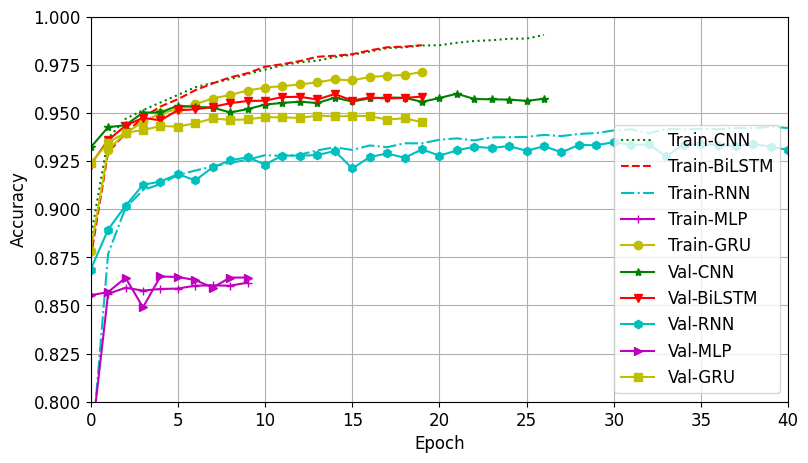

In [44]:
plt.figure(1)
plt.figure(figsize=(9,5))
plt.rcParams.update({'font.size': 12})
# summarize for accuracy
plt.plot(CNNhistory.history['accuracy'], 'g:')
plt.plot(LSTMhistory.history['accuracy'], 'r--')
plt.plot(RNNhistory.history['accuracy'], 'c-.')
plt.plot(DNNhistory.history['accuracy'], 'm-+')
plt.plot(GRUhistory.history['accuracy'], 'y-o')
plt.plot(CNNhistory.history['val_accuracy'], 'g-*')
plt.plot(LSTMhistory.history['val_accuracy'], 'r-v')
plt.plot(RNNhistory.history['val_accuracy'], 'c-h')
plt.plot(DNNhistory.history['val_accuracy'], 'm->')
plt.plot(GRUhistory.history['val_accuracy'], 'y-s')
plt.grid('True')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.8, 1)
plt.xlim(0,40)
plt.legend(['Train-CNN', 'Train-BiLSTM', 'Train-RNN', 'Train-MLP', 'Train-GRU','Val-CNN',\
            'Val-BiLSTM', 'Val-RNN', 'Val-MLP', 'Val-GRU'], loc='lower right')

plt.gcf().savefig('accR1.eps', format='eps', dpi=600)

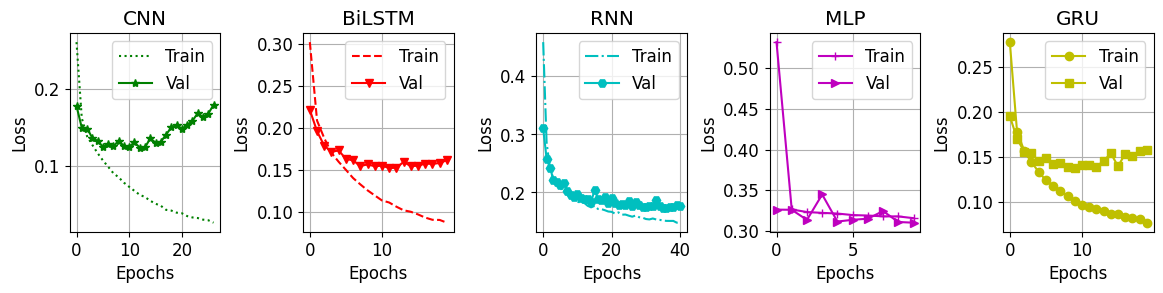

In [45]:
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
fig.tight_layout(pad=2.0)             #space between plots
#fig.set_size_inches(9,6)
plt.rcParams.update({'font.size': 12}) 

axes[0].plot(CNNhistory.history['loss'], 'g:')
axes[1].plot(LSTMhistory.history['loss'], 'r--')
axes[2].plot(RNNhistory.history['loss'], 'c-.')
axes[3].plot(DNNhistory.history['loss'], 'm-+')
axes[4].plot(GRUhistory.history['loss'], 'y-o')


axes[0].plot(CNNhistory.history['val_loss'], 'g-*')
axes[1].plot(LSTMhistory.history['val_loss'], 'r-v')
axes[2].plot(RNNhistory.history['val_loss'], 'c-H')
axes[3].plot(DNNhistory.history['val_loss'], 'm->')
axes[4].plot(GRUhistory.history['val_loss'], 'y-s')


axes[0].set_title('CNN')
axes[1].set_title('BiLSTM')
axes[2].set_title('RNN')
axes[3].set_title('MLP')
axes[4].set_title('GRU')

axes[0].grid(True)
axes[1].grid(True)
axes[2].grid(True)
axes[3].grid(True)
axes[4].grid(True)

axes[0].legend(['Train', 'Val'], loc='upper right')
axes[1].legend(['Train', 'Val'], loc='upper right')
axes[2].legend(['Train', 'Val'], loc='upper right')
axes[3].legend(['Train', 'Val'], loc='upper right')
axes[4].legend(['Train', 'Val'], loc='upper right')

for i in range(0,5):
  axes[i].set_xlabel('Epochs')
  axes[i].set_ylabel('Loss')


plt.gcf().savefig('lossR1.eps', format='eps', dpi=600)

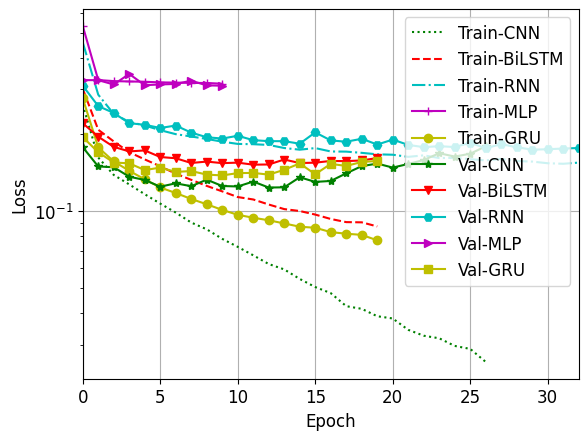

In [46]:
plt.figure(2)
plt.plot(CNNhistory.history['loss'], 'g:')
plt.plot(LSTMhistory.history['loss'], 'r--')
plt.plot(RNNhistory.history['loss'], 'c-.')
plt.plot(DNNhistory.history['loss'], 'm-+')
plt.plot(GRUhistory.history['loss'], 'y-o')
plt.plot(CNNhistory.history['val_loss'], 'g-*')
plt.plot(LSTMhistory.history['val_loss'], 'r-v')
plt.plot(RNNhistory.history['val_loss'], 'c-H')
plt.plot(DNNhistory.history['val_loss'], 'm->')
plt.plot(GRUhistory.history['val_loss'], 'y-s')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train-CNN', 'Train-BiLSTM', 'Train-RNN', 'Train-MLP', 'Train-GRU','Val-CNN',\
            'Val-BiLSTM', 'Val-RNN', 'Val-MLP', 'Val-GRU'], loc='upper right')
plt.grid('True')
plt.xlim(0,32)
plt.yscale('log')

<Figure size 640x480 with 0 Axes>

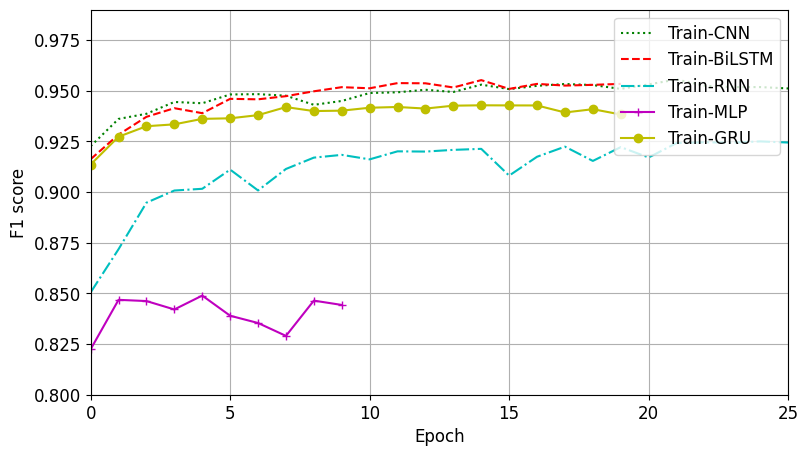

In [47]:
plt.figure(1)
plt.figure(figsize=(9,5))
plt.rcParams.update({'font.size': 12})
# summarize for accuracy
plt.plot(CNNhistory.history['val_f1_score'], 'g:')
plt.plot(LSTMhistory.history['val_f1_score'], 'r--')
plt.plot(RNNhistory.history['val_f1_score'], 'c-.')
plt.plot(DNNhistory.history['val_f1_score'], 'm-+')
plt.plot(GRUhistory.history['val_f1_score'], 'y-o')
plt.grid('True')
plt.ylabel('F1 score')
plt.xlabel('Epoch')
plt.ylim(0.8, 0.99)
plt.xlim(0,25)
plt.legend(['Train-CNN', 'Train-BiLSTM', 'Train-RNN', 'Train-MLP', 'Train-GRU','Val-CNN',\
            'Val-BiLSTM', 'Val-RNN', 'Val-MLP', 'Val-GRU'], loc='upper right')

## 1.11 Statistics

In [48]:
y_predCNN =(CNNmodel.predict(x_test) > 0.5).astype("int32")
y_predLSTM =(LSTMmodel.predict(x_test) > 0.5).astype("int32")
y_predRNN =(RNNmodel.predict(x_test) > 0.5).astype("int32")
y_predGRU =(GRUmodel.predict(x_test) > 0.5).astype("int32")
y_predDNN =(DNNmodel.predict(x_test) > 0.5).astype("int32")

630/630 [==============================] - 3s 5ms/step


In [49]:
# Finding precision and recall
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_test, y_predLSTM))
print(recall_score(y_test, y_predLSTM))

print(precision_score(y_test, y_predRNN))
print(recall_score(y_test, y_predRNN))

print(precision_score(y_test, y_predCNN))
print(recall_score(y_test, y_predCNN))

print(precision_score(y_test, y_predGRU))
print(recall_score(y_test, y_predGRU))

print(precision_score(y_test, y_predDNN))
print(recall_score(y_test, y_predDNN))

0.9640665104341033
0.9489235500878734
0.9482639687284433
0.9059753954305799
0.9630541871921182
0.944859402460457
0.9494476062939404
0.9345342706502636
0.8737344350052368
0.8246924428822495


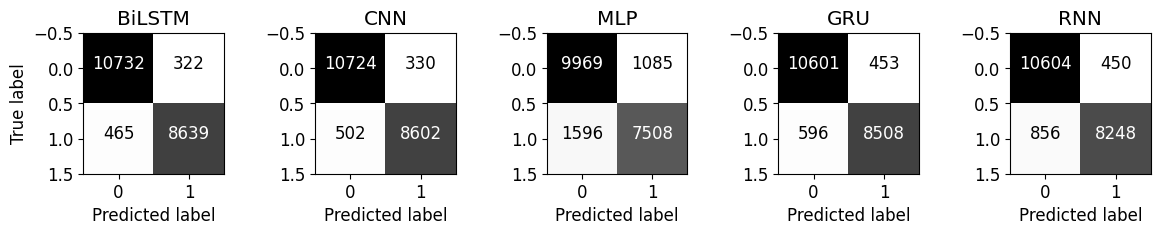

In [50]:
# Constructing the confusion matrix.
from sklearn.metrics import confusion_matrix
%matplotlib inline
import itertools

cm1 = confusion_matrix(y_true=y_test, y_pred=y_predLSTM)
cm2 = confusion_matrix(y_true=y_test, y_pred=y_predCNN)
cm3 = confusion_matrix(y_true=y_test, y_pred=y_predDNN)
cm4 = confusion_matrix(y_true=y_test, y_pred=y_predGRU)
cm5 = confusion_matrix(y_true=y_test, y_pred=y_predRNN)


fig, axes = plt.subplots(1, 5, figsize=(12, 4))
fig.tight_layout(pad=2.5)             #space between plots
#fig.set_size_inches(9,6)
plt.rcParams.update({'font.size': 12}) 
cmap=plt.cm.Greys

axes[0].imshow(cm1, interpolation='nearest', cmap=cmap)
axes[0].set_title('BiLSTM')
#axes[0].colorbar()
thresh = cm1.max() / 2.
for i, j in itertools.product(range(cm1.shape[0]), range(cm1.shape[1])):
  axes[0].text(j, i, cm1[i, j],
  horizontalalignment="center",
  color="white" if cm1[i, j] > thresh else "black")
  axes[0].set_ylabel('True label')
  axes[0].set_xlabel('Predicted label')

axes[1].imshow(cm2, interpolation='nearest', cmap=cmap)
axes[1].set_title('CNN')
thresh = cm2.max() / 2.
for i, j in itertools.product(range(cm2.shape[0]), range(cm2.shape[1])):
  axes[1].text(j, i, cm2[i, j],
  horizontalalignment="center",
  color="white" if cm2[i, j] > thresh else "black")
  #axes[1].set_ylabel('True label')
  axes[1].set_xlabel('Predicted label')

axes[2].imshow(cm3, interpolation='nearest', cmap=cmap)
axes[2].set_title('MLP')
thresh = cm3.max() / 2.
for i, j in itertools.product(range(cm3.shape[0]), range(cm3.shape[1])):
  axes[2].text(j, i, cm3[i, j],
  horizontalalignment="center",
  color="white" if cm3[i, j] > thresh else "black")
  #axes[2].set_ylabel('True label')
  axes[2].set_xlabel('Predicted label')

axes[3].imshow(cm4, interpolation='nearest', cmap=cmap)
axes[3].set_title('GRU')
thresh = cm3.max() / 2.
for i, j in itertools.product(range(cm4.shape[0]), range(cm4.shape[1])):
  axes[3].text(j, i, cm4[i, j],
  horizontalalignment="center",
  color="white" if cm4[i, j] > thresh else "black")
  #axes[3].set_ylabel('True label')
  axes[3].set_xlabel('Predicted label')


axes[4].imshow(cm5, interpolation='nearest', cmap=cmap)
axes[4].set_title('RNN')
thresh = cm3.max() / 2.
for i, j in itertools.product(range(cm5.shape[0]), range(cm5.shape[1])):
  axes[4].text(j, i, cm5[i, j],
  horizontalalignment="center",
  color="white" if cm5[i, j] > thresh else "black")
  #axes[4].set_ylabel('True label')
  axes[4].set_xlabel('Predicted label')


#plt.show(block=False)

plt.gcf().savefig('cmR1.pdf', format='pdf', dpi=1200)

## 1.12 Testing 

In [51]:
testename = prepare_encod_names({"cibely"})   # Now the names are encod as a vector of numbers with weight
resu=(LSTMmodel.predict(testename) > 0.5).astype("int32")
if int(resu)==1:
  print('M')
else:
  print('F')

1/1 [==============================] - 0s 49ms/step
F
